##### Face detector and pose detector
The class `face_detector` contains a pretrained version of the `img2pose` model, which is finetuned to on frontal faces (like phone selfie cameras, webcams). It is imported through `py-feat`. It contains a `detection threshold` hyperparameter in the range of `[0,1]`. The model returns a dataframe where each row is a bounding box coordinates accompanied by 3 facial poses. We can also keep track of which frame the bounding box belongs in.

#### Video cropper
The video cropper checks the coordinates of each bounding box to determine the bounding box values closest to the top, bottom, left and right of the screen. It then crops crops the video to a lower resolution while maintaining all the neccessary information to extract features.

##### Face-tracker
The class `face_persistence_model` is based on the `face_recognition` library, using the `face_locations`, `face_encoding` and `face_landmarks `functions. `face_locations` searches a frame for faces and returns bounding box coordinates. `face_encoding` checks these faces to see if they can recognize the person. When it encounters a "new" face it saves some metadata. Then when detecting future faces it will check this new face against all the metadata files. `face_landmarks` returns 68 `x` and 68 `y` coordinates, representing the landmarks on a face. 

The inputs for the model are:
1. `TOLERANCE`: A number [0,1] that alters how the model recognizes faces. A too low tolerance leads to the same face getting detected as different unique faces, too high tolerance leads to multiple faces being detected as the same person 
2. `filename`: The name of the videofile being analyzed. Must contain extension such as ".mp4".
3. `frameSkips`: This integer value represents how often a frame is skipped, i.e. if `frameSkips=3` every 3rd frame is skipped.
4. `model`: Face location model choice of `['cnn', 'hog']`. While 'hog' is quicker (especially on CPU), 'cnn' is more accurate and utilizes GPU.
5. `modelSize`: Size of the face encoding model, choice of `['small', 'large']`.

#### AU and emotion detector
This class containg 2 models, namely a pretrained `XGB` model for detecting AU's and a `svm`/`resmasknet` model for emotion detection, which can be given as an input (`svm` is default).

The class uses facial landmarks and video footage as an input.




In [ ]:
import gc
import pandas as pd
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Models.face_detection.face_detection import face_detector
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
from Models.eye_tracking.mediapipe_wrapper import mediaPipeModel
from Preprocessing.personLabeler import personPersistenceManual
from Preprocessing.videoCropper import videoCropper
from Preprocessing.kalman import filterKalman
import time

## CALL THIS WHEN IMPORTING FROM PANDAS
def convert_whole_number_columns_to_int(df):
    for col in df.columns:
        # Check if the column has a numeric data type
        if pd.api.types.is_numeric_dtype(df[col]):
            # Check if all values in the column are whole numbers (i.e., the same when rounded)
            if df[col].eq(df[col].round()).all():
                # Convert the column to integers
                df[col] = df[col].astype(int)
    return df

filename = 'meeting_7_trimmed.mp4'
mapName = 'meeting_7'
## TODO: batch size for models after facepredict and videocrop should correlate with number of people
##       example: with 3 people, batch_size=32 is perfect for aus+emo, but with 1 person batch_size=32 uses too little gpu memory and is slow.        

# facePredict = face_detector(filename=filename, detection_threshold=0.7, batch_size=12)
# output = facePredict.runModelBatch()
# output.to_csv(f'mapje/{mapName}/1_faceDetected.csv', index=False)
# del facePredict
# gc.collect()
# print('collected bounding_boxes')

# # output = pd.read_csv(f'mapje/{mapName}/1_faceDetected.csv')
# # output.fillna(method='ffill', inplace=True)
# # output.to_csv('mapje/1.csv', index=False)

# videoCrop = videoCropper(output, filename, displayVideo=False, saveCSV=False)
# output = videoCrop.runModel(csvName='test')
filename = 'cropped_'+filename
# output.to_csv(f'mapje/{mapName}/2_cropped.csv', index=False)
# del videoCrop
# gc.collect()
# print('cropped video')

# p = personPersistenceManual(overlap_ratio=0.02)
# output = p.assign_person_id(output)
# output.to_csv(f'mapje/{mapName}/3_persistence.csv', index=False)
# del p
# gc.collect()
# print('did person tracking')

# # output = pd.read_csv(f'mapje/{mapName}/3_persistence.csv')
# # output = convert_whole_number_columns_to_int(output)

# face_tracker_model = face_persistence_model(TOLERANCE=0.6, filename=filename, model='cnn', modelSize='large', landmark_cuda=True)
# output = face_tracker_model.runDetectionTrackOnlyBatch(output, False, batch_size=44)
# output.to_csv(f'mapje/{mapName}/4_landmarks.csv', index=False)
# del face_tracker_model
# gc.collect()
# print('completed landmarks')

output = pd.read_csv(f'mapje/{mapName}/4_landmarks.csv')
#output = output[output['Person'] != 5].reset_index(drop=True)
output = convert_whole_number_columns_to_int(output)

# cols = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
# kalmanFilter = filterKalman(output, cols)
# output = kalmanFilter.runFilter()
# output.to_csv(f'mapje/{mapName}/5_kalman.csv', index=False)
# del kalmanFilter, cols
# gc.collect()
# print('completed kalman')

# output = pd.read_csv(f'mapje/{mapName}/5_kalman.csv')
# output = convert_whole_number_columns_to_int(output)

au_emo_detector = AuEmoDetectors(filename=filename, df=output, emoModel='resmasknet', device='cuda')
output = au_emo_detector.runModel(batch_size=128) 
output.to_csv(f'mapje/{mapName}/6_au_emo.csv', index=False)
del au_emo_detector
gc.collect()
print('completed au+emo')

## output = pd.read_csv(f'mapje/{mapName}/6_au_emo.csv')

media = mediaPipeModel(filename=filename, df=output, display=False)
output = media.runModel()
output.to_csv(f'mapje/{mapName}/7_mediapipe.csv', index=False)
del media
gc.collect()


In [21]:
import pandas as pd
import numpy as np
from Preprocessing.emotionMirroring import emotionMirroring
from Preprocessing.eyeFeatures import eyePreprocessor
ear = eyePreprocessor()
def calculate_differences(df, feature):
    df[feature + '_diff'] = df.groupby('Person')[feature].diff().fillna(0).round(3)
emoMirroring = emotionMirroring()
for meetingNr in range(7,8):
    print(meetingNr)
    output = pd.read_csv(f'mapje/meeting_{meetingNr}/7_mediapipe.csv')
    output = emoMirroring.runModel(output)
    output.to_csv(f'mapje/meeting_{meetingNr}/8_emotionMirrored_no_kalmann.csv', index=False)

    output = ear.get_EAR(output)
    output = ear.pupilFeatures(output)

    output.sort_values(by=['Frame', 'Person'], inplace=True)
    output.reset_index(drop=True, inplace=True)
    
    # Define a function to calculate the differences between two consecutive frames for a given feature

    au_features = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9', 'AU10', 'AU11',
                'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU24', 'AU25', 'AU26',
                'AU28', 'AU43']

    # List of emotion features
    emotion_features = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

    # Calculate differences for AU features
    for feature in au_features:
        calculate_differences(output, feature)

    # Calculate differences for emotion features
    for feature in emotion_features:
        calculate_differences(output, feature)

    # Calculate differences for emotion mirroring
    calculate_differences(output, 'emotion_mirroring')

    output.to_csv(f'mapje/meeting_{meetingNr}/9_temporaled_no_kalmann.csv', index=False)

7


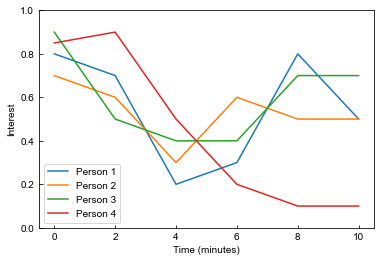

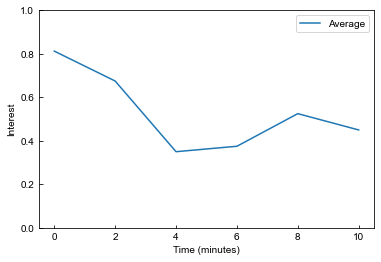

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time data (x-axis) from 0 to 10 in increments of 0.1 minutes
time = np.arange(0, 10.1, 2)

interestlist = []
interestlist.append([0.8, 0.7, 0.2, 0.3, 0.8, 0.5])
interestlist.append([0.7, 0.6, 0.3, 0.6, 0.5, 0.5])
interestlist.append([0.9, 0.5, 0.4, 0.4, 0.7, 0.7])
interestlist.append([0.85, 0.9, 0.5, 0.2, 0.1, 0.1])
# Generate interest data (y-axis) between 0 and 1 for each person
interest_data = {}
for i, interest in zip(range(1, 5), interestlist):
    interest_data[f"Person {i}"] = interest

# Create the plot
fig, ax = plt.subplots()

# Plot the data for each person
for label, interest in interest_data.items():
    ax.plot(time, interest, label=label)

# Set the x-axis and y-axis labels
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Interest")

# Set the y-axis limits
ax.set_ylim(0, 1)

ax.tick_params(axis='both', direction='in', pad=5)

# Add a legend
ax.legend()

# Save the plot as a PNG file
plt.savefig("timeline_graph.png", dpi=300, bbox_inches="tight")
# Add a legend
ax.legend()
# Show the plot
plt.show()

fig2, ax2 = plt.subplots()

# Compute the average interest at each time point and plot it
average_interest = np.mean(list(interest_data.values()), axis=0)
ax2.plot(time, average_interest, label='Average')

# Set the x-axis and y-axis labels
ax2.set_xlabel("Time (minutes)")
ax2.set_ylabel("Interest")

# Set the y-axis limits
ax2.set_ylim(0, 1)

ax2.tick_params(axis='both', direction='in', pad=5)

# Add a legend
ax2.legend()

# Show the plot
plt.show()


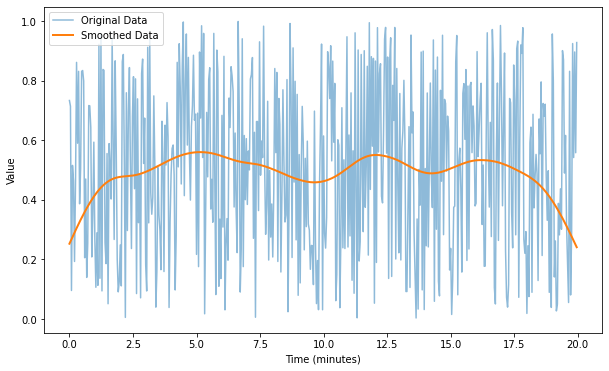

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
time = np.arange(0, 20, 1/25)
data = np.random.rand(len(time))

# Apply smoothing using a rolling window
def smooth_data(data, window_size, method='average'):
    if method == 'average':
        window = np.ones(window_size) / window_size
        smoothed_data = np.convolve(data, window, mode='same')
    elif method == 'gaussian':
        window = np.hanning(window_size)
        window /= window.sum()
        smoothed_data = np.convolve(data, window, mode='same')
    else:
        raise ValueError(f"Unknown method: {method}")
    return smoothed_data

window_size = 25 * 5  # Experiment with different window sizes
smoothed_data = smooth_data(data, window_size, method='gaussian')  # or method='gaussian'

# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time, data, label='Original Data', alpha=0.5)
plt.plot(time, smoothed_data, label='Smoothed Data', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Value')
plt.legend()
plt.show()